<a href="https://colab.research.google.com/github/ykato27/PyPortfolioOpt/blob/main/PyPortfolioOpt_RiskReturnModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Risk and return models
In this section, we compare how well the different risk models predict an out-of-sample covariance matrix, and how well the different returns models predict out-of-sample returns.

In [1]:
!pip install PyPortfolioOpt
!pip install japanize_matplotlib

     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 1.3MB 9.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736145 sha256=483c917e77e1ad5f69291a67d056f27134ab4af0b44370ad5563f413074b9d0b
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31
     |████████████████████████████████| 4.1MB 5.2MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=2aebebeae38541d9363dff41d42d9ca3a85e3d3c380fee8902dc95335f77e380
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfull

### Risk models

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語化対応
import japanize_matplotlib
#日本語フォント設定
sns.set(font="IPAexGothic")

import pandas_datareader as pdr
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
pypfopt.__version__

'1.4.2'

In [3]:
# リスト: ライトアップ、エフオン、アルファポリス、タケエイ、ENEOS、金、プラチナ、銀
symbols = ['6580.jp','9514.jp','9467.jp','2151.jp','5020.jp','1540.jp','1542.jp','1541.jp']
company_list = ['ライトアップ','エフオン','アルファポリス','タケエイ','ENEOS','金','プラチナ','銀']

# 価格データの取得と整形（終値だけ使用）
pdr =pdr.stooq.StooqDailyReader(symbols=symbols, start='2/11/20', end='1/8/21').read().sort_values(by='Date',ascending=True)
df = pdr['Close']
df.columns = company_list

df.head()

,ライトアップ,エフオン,アルファポリス,タケエイ,ENEOS,金,プラチナ,銀
Date,,,,,,,,
2020-02-12,1296.0,756.69,2685.0,1027.20,439.62,5340.0,5700.0,3185.0
2020-02-13,1321.0,677.76,2732.0,1029.14,444.51,5390.0,5720.0,3185.0
2020-02-14,1291.0,696.51,2395.0,1030.10,439.70,5390.0,5750.0,3195.0
2020-02-17,1142.0,669.87,2365.0,999.18,438.87,5490.0,5770.0,3205.0
2020-02-18,1105.0,660.01,2386.0,982.74,431.57,5490.0,5850.0,3200.0


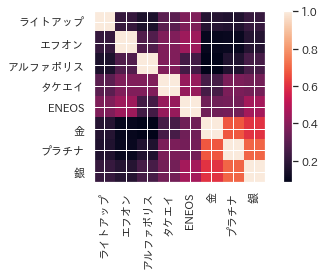

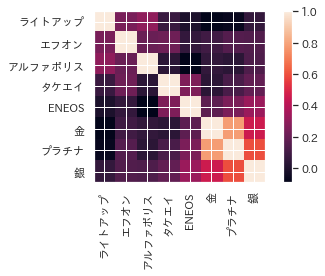

In [4]:
past_df, future_df = df.iloc[:-100], df.iloc[-100:]
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

We can see that visually, the sample covariance does not capture some of the new features of the covariance matrix, for example the highly correlated group of FAANG stocks. We may be able to improve this by using an exponentially-weighted covariance matrix, which gives more weight to recent data. We can also look at how each model predicts future variance.

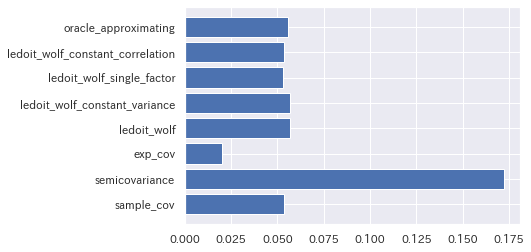

In [5]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

We can see that the exponential covariance matrix is a much better estimator of future variance compared to the other models. Its mean absolute error is 2%, which is actually pretty good. Let's visually compare the exponential cov matrix to the realised future cov matrix:

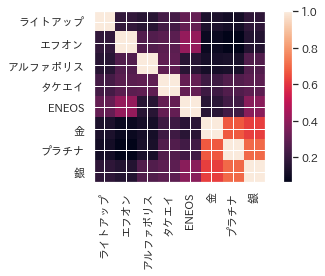

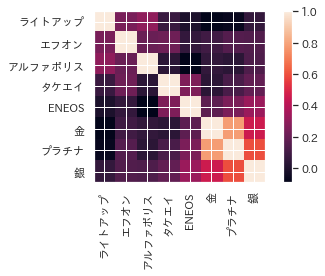

In [6]:
exp_cov = risk_models.exp_cov(past_df)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

### Returns
What about returns? Will the exponentially-weighted returns similarly be the best performer?

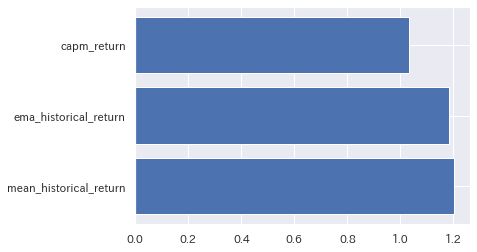

In [7]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

In [8]:
print(mean_abs_errors)

[1.202423318610936, 1.1848200669747966, 1.0334686902745205]


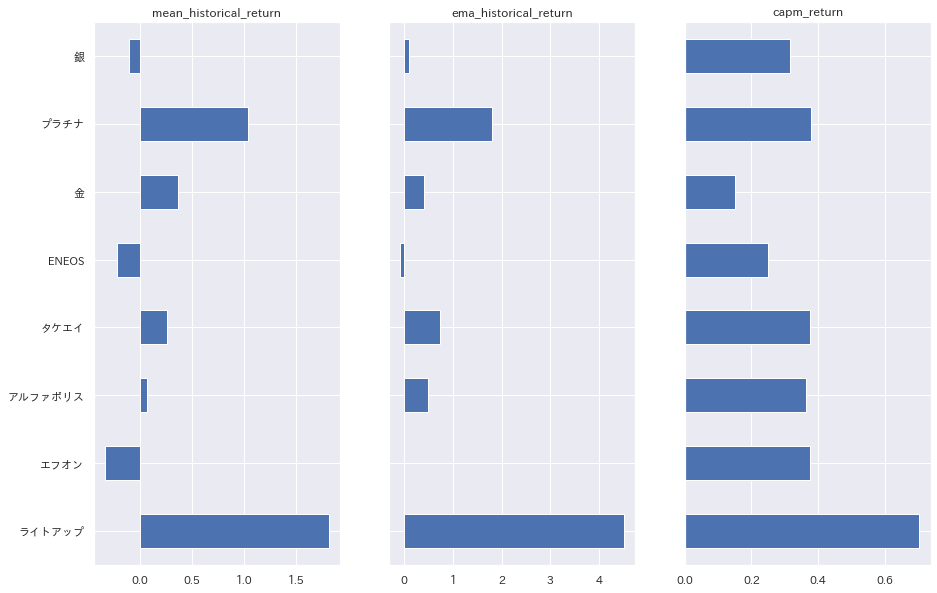

In [9]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])